# Data 612 Project 3

Matthew Tillmawitz

## Introduction

The assignment is to implement a recommender system using a matrix factorization method. We will be using the MovieLens dataset, for which the full citation can be found at the end of this document, for training and evaluation of our model. Instead of using techniques such as ALS or SVD which require no missing data, we will be implementing a model using Stochastic Gradient Descent (SGD) to avoid having to impute data. Data imputation for sparse datasets can be difficult to do without introducing bias or amplifying noise in datasets, which means modeling techniques like SGD which are able to handle missingness are preferable.

## Stochastic Gradient Descent for Recommender Systems

Stochastic Gradient Descent is an optimization function that seeks to minimize a loss function by iteratively updating parameters. It functions by iteratively sampling the dataset and estimating the gradient of the loss function and updating parameters. The gradient is simply a vector or vector field that indicates the direction of greatest change for a scalar function, which in the context of parameter estimation indicates how the parameter should be adjusted. The equation for the gradient is the partial derivative of the loss function with respect to the user and item parameters. For matrix factorization and most other use cases the loss function is the regularized squared error. A learning rate is used to determine the step size of the adjustments and prevent oscillating over minima while maintaining a reasonable rate of improvement. Using a single sample or, more commonly, a small batch of the data in each iteration allows the algorithm to perform well on datasets that cannot fit in memory.

In the context of matrix factorization we are trying to approximate an n by m matrix $R$ such that $R = UV^T$ where:

* $U$ is an n by k matrix which represents the user factors
* $V$ is an m by k matrix which represents the item factors
* $k$ is the number of latent factors

The matrices $U$ and $V$ are randomly populated at the beginning. For each iteration a random observation (or group of observations, but for this explanation we will assume one), $R_{ij}$ is selected, the dot product of $U_i$ and $V_j$ is calculated, and the error is determined based on the difference from the observed value. The estimates of $U_i$ and $V_j$ are then adjusted based on the gradient of the loss function and according to the learning rate and with regards to a regularization parameter. Because we are able to select which observations are sampled, we can choose from only the known values which means we do not need to populate missing data. Since recommender systems usually deal with very sparse data this dramatically decreases the number of calculations and avoids any data issues from imputation.

## Model Implementation

We will be using the sparse package from the scipy for the core of the sparse matrix factorization. These libraries provide some useful objects for storing and accessing sparse matrices as well as efficient matrix factorization implementations. The recommender is implemented as a class in order to facilitate parallelization when training multiple models, as training an SGD model is largely sequential in nature. Unfortunately model training times for large parameter grids were too long even with parallelization, and the related code has been removed to improve readability. The class definition is split across multiple code chunks to allow for commentary on the implementation.

In [102]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import product

In [103]:
class SparseSGDRecommender:
    def __init__(self, n_factors = 50, learning_rate = 0.01, regularization = 0.02, n_epochs = 100, random_state = 8675309):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.random_state = random_state

Model training is performed over a set number of epochs. The equations for adjusting biases and updating factors are discussed thoroughly on [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). It should be noted the factorized matrices are not making use of the sparse matrix data structures, as they are dense by design and the number of factors chosen should be much smaller than the dimensions of the full ratings matrix.

In [104]:
def fit(self, ratings_matrix, user_ids = None, item_ids = None):
    # Ratings matrix must be a csr_matrix for efficient computation
    if not sparse.isspmatrix_csr(ratings_matrix):
            ratings_matrix = ratings_matrix.tocsr()

    self.ratings_matrix = ratings_matrix
    self.n_users, self.n_items = ratings_matrix.shape

    self.user_ids = user_ids if user_ids is not None else list(range(self.n_users))
    self.item_ids = item_ids if item_ids is not None else list(range(self.n_items))

    np.random.seed(self.random_state)
    self.user_factors = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
    self.item_factors = np.random.normal(0, 0.1, (self.n_items, self.n_factors))

    self.user_biases = np.zeros(self.n_users)
    self.item_biases = np.zeros(self.n_items)
    self.global_bias = ratings_matrix.data.mean()

    # Ratings go from 1-5 so non-zero is the same as non-empty
    self.observed_users, self.observed_items = ratings_matrix.nonzero()
    # We want the array one dimensional, so that we can simplify the permutation logic
    self.observed_ratings = np.array(ratings_matrix.data)
    self.n_observations = len(self.observed_ratings)

    self.training_losses = []

    for epoch in range(self.n_epochs):
        # Shuffle the observed ratings for each epoch to prevent learning from input order
        shuffle_idx = np.random.permutation(self.n_observations)
        epoch_loss = 0
        
        # Iterating through all observations, may want to do small batch if too slow
        for idx in shuffle_idx:
            user_idx = self.observed_users[idx]
            item_idx = self.observed_items[idx]
            rating = self.observed_ratings[idx]
            
            prediction = (self.global_bias + 
                        self.user_biases[user_idx] + 
                        self.item_biases[item_idx] +
                        np.dot(self.user_factors[user_idx], self.item_factors[item_idx]))
            
            error = rating - prediction
            epoch_loss += error ** 2
            
            self.user_biases[user_idx] += self.learning_rate * (error - self.regularization * self.user_biases[user_idx])
            self.item_biases[item_idx] += self.learning_rate * (error - self.regularization * self.item_biases[item_idx])
            
            # Update factors using gradient descent
            user_factors_old = self.user_factors[user_idx].copy()
            self.user_factors[user_idx] += self.learning_rate * (error * self.item_factors[item_idx] - 
                                                                self.regularization * self.user_factors[user_idx])
            self.item_factors[item_idx] += self.learning_rate * (error * user_factors_old - 
                                                                self.regularization * self.item_factors[item_idx])
        
        # Track rmse for visualizing training improvements
        rmse = np.sqrt(epoch_loss / self.n_observations)
        self.training_losses.append(rmse)

SparseSGDRecommender.fit = fit

Simple functions to make model predictions and evaluate the results.

In [105]:
def predict(self, user_idx = None, item_idx = None):
    return (self.global_bias + 
            self.user_biases[user_idx] + 
            self.item_biases[item_idx] +
            np.dot(self.user_factors[user_idx], self.item_factors[item_idx]))

SparseSGDRecommender.predict = predict

In [106]:
def evaluate(self, test_matrix):
    test_users, test_items = test_matrix.nonzero()
    test_ratings = test_matrix.data

    predictions = []
    # zip fetches the users and items as a tuple, lets us iterate through both sets more easily
    for user_idx, item_idx, in zip(test_users, test_items):
        pred = self.predict(user_idx, item_idx)
        predictions.append(pred)

    # Didn't end up using MAE as it correlated perfectly with RMSE
    rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
    mae = np.mean(np.abs(test_ratings - np.array(predictions)))

    return {'RMSE': rmse, "MAE": mae}

SparseSGDRecommender.evaluate = evaluate

A function for training and evaluating a model. Used to make iterating through a parameter grid easier.

In [107]:
# Trains a single model and returns the evaluation
def train_and_evaluate_model(params_dict, train_matrix, test_matrix, user_ids, item_ids):
    model = SparseSGDRecommender(**params_dict)
    model.fit(train_matrix, user_ids=user_ids, item_ids=item_ids)
    
    test_metrics = model.evaluate(test_matrix)
    final_train_rmse = model.training_losses[-1]
    
    result = {
        'params': params_dict,
        'test_rmse': test_metrics['RMSE'],
        'test_mae': test_metrics['MAE'],
        'train_rmse': final_train_rmse,
        'converged': len(model.training_losses) == params_dict['n_epochs']
    }
    
    return result

# Model Training

The data is divided into training and tests by shuffling the populated indices and dividing along an 80/20 split. It is important to note that we only consider the populated data, and the ratings range from 1-5 stars so non-zero is the same as non-empty. The grid is populated with a relatively small number of values due to the time it takes to train the models, but should be enough to give an idea of the trends in hyperparameter tuning.

In [72]:
# Loading data using the built-in function in surprise library
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# Converting data from the surprise library format, then splitting
ratings_list = [(uid, iid, float(rating)) for uid, iid, rating, timestamp in raw_ratings]
np.random.seed(8675309)
np.random.shuffle(ratings_list)

# Data was shuffled so cutting on index is fine
split_idx = int(len(ratings_list) * 0.8)
train_ratings = ratings_list[:split_idx]
test_ratings = ratings_list[split_idx:]

all_users = {uid for uid, iid, rating in ratings_list}
all_items = {iid for uid, iid, rating in ratings_list}

user_ids = sorted(all_users)
item_ids = sorted(all_items)

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_mapping = {item_id: idx for idx, item_id in enumerate(item_ids)}

n_users = len(user_ids)
n_items = len(item_ids)

# Put data into a sparse matrix data structure to speed things up
train_rows = [user_mapping[uid] for uid, iid, rating in train_ratings]
train_cols = [item_mapping[iid] for uid, iid, rating in train_ratings]
train_data = [rating for uid, iid, rating in train_ratings]

train_matrix = sparse.csr_matrix(
    (train_data, (train_rows, train_cols)),
    shape=(n_users, n_items)
)

test_rows = [user_mapping[uid] for uid, iid, rating in test_ratings]
test_cols = [item_mapping[iid] for uid, iid, rating in test_ratings]
test_data = [rating for uid, iid, rating in test_ratings]

test_matrix = sparse.csr_matrix(
    (test_data, (test_rows, test_cols)),
    shape=(n_users, n_items)
)

In [73]:
# Defining a grid was a pain, look up easier ways of doing this
tuning_grid = {
        'n_factors': [50, 75, 100],
        'learning_rate': [0.005, 0.01],  
        'regularization': [0.01, 0.02, 0.03],
        'n_epochs': [80],
        'random_state': [8675309]
    }

param_combinations = []
for combination in product(*tuning_grid.values()):
    param_dict = dict(zip(tuning_grid.keys(), combination))
    param_combinations.append(param_dict)

In [74]:
results = []
    
for i, params_dict in enumerate(param_combinations):    
    # Try catch for all the times I wrote it wrong
    try:
        # Create and train model
        model = SparseSGDRecommender(**params_dict)
        model.fit(train_matrix, user_ids=user_ids, item_ids=item_ids)
        test_metrics = model.evaluate(test_matrix)
        final_train_rmse = model.training_losses[-1]
        
        result = {
            'params': params_dict,
            'test_rmse': test_metrics['RMSE'],
            'test_mae': test_metrics['MAE'],
            'train_rmse': final_train_rmse,
            'converged': len(model.training_losses) == params_dict['n_epochs']
        }
        results.append(result)
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        error_result = {
            'params': params_dict,
            'error': str(e),
            'test_rmse': float('inf'),
            'test_mae': float('inf'),
            'train_rmse': float('inf'),
            'training_time': 0,
            'converged': False
        }
        results.append(error_result)


In [75]:
# Only getting the non-error results
results_df = []
for result in results:
    if 'error' not in result:
        row = result['params'].copy()
        row.update({
            'test_rmse': result['test_rmse'],
            'test_mae': result['test_mae'], 
            'train_rmse': result['train_rmse'],
            'converged': result['converged']
        })
        results_df.append(row)

df = pd.DataFrame(results_df)

# Results Analysis

The optimal model had fairly good results on the test set, with an RMSE of 0.96 and MAE of 0.76. The gap in values indicates that the model performs well the majority of the time, getting within 1 point of the actual value, but has some large errors which result in the much larger RMSE. If trying to improve the model additional analysis of the cases resulting in these large RMSE values could provide some insight into what targeted improvements could be made.

In [76]:
best_idx = df['test_rmse'].idxmin()
best_params = df.loc[best_idx]

print(best_params)

n_factors              100
learning_rate         0.01
regularization        0.03
n_epochs                80
random_state       8675309
test_rmse         0.961594
test_mae          0.755903
train_rmse        0.265212
converged             True
Name: 17, dtype: object


Looking at how the models performed across the different hyperparameter values, it is clear the learning rate has very little impact on model performance. Both the regularization rate and number of factors have a meaningful impact on model performance with larger values for both producing better performing models. Taking into consideration the fact we did not alter the number of epochs due to compute constraints, this could indicate we are not iterating enough to reach the optimal values for our factored matrices. The large performance improvement we see with larger regularization values in particular supports this, indicating there is likely more room for performance improvement through compute power and a larger number of iterations alone.

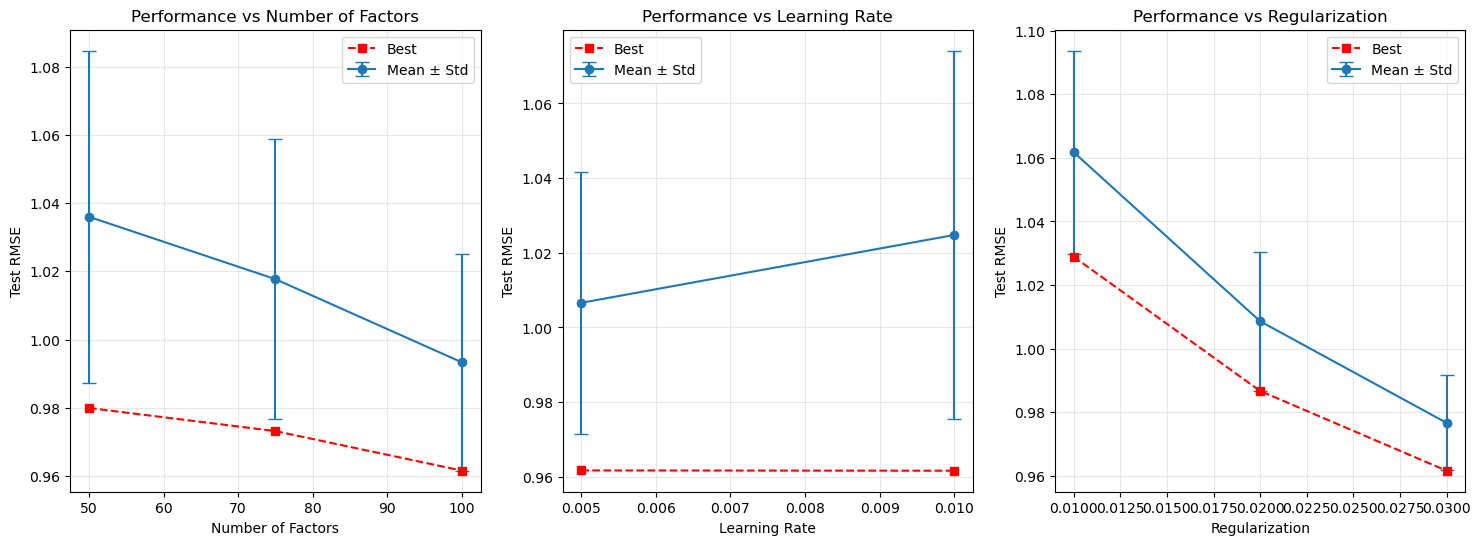

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
# Performance by number of factors
if len(df['n_factors'].unique()) > 1:
    factor_stats = df.groupby('n_factors')['test_rmse'].agg(['mean', 'std', 'min']).reset_index()
    axes[0].errorbar(factor_stats['n_factors'], factor_stats['mean'], 
                        yerr=factor_stats['std'], marker='o', capsize=5, label='Mean ± Std')
    axes[0].plot(factor_stats['n_factors'], factor_stats['min'], 
                    'r--', marker='s', label='Best')
    axes[0].set_xlabel('Number of Factors')
    axes[0].set_ylabel('Test RMSE')
    axes[0].set_title('Performance vs Number of Factors')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'Only one n_factors value tested', 
                    ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Number of Factors (Single Value)')

# Performance by learning rate
if len(df['learning_rate'].unique()) > 1:
    lr_stats = df.groupby('learning_rate')['test_rmse'].agg(['mean', 'std', 'min']).reset_index()
    axes[1].errorbar(lr_stats['learning_rate'], lr_stats['mean'], 
                        yerr=lr_stats['std'], marker='o', capsize=5, label='Mean ± Std')
    axes[1].plot(lr_stats['learning_rate'], lr_stats['min'], 
                    'r--', marker='s', label='Best')
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Test RMSE')
    axes[1].set_title('Performance vs Learning Rate')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Only one learning_rate value tested', 
                    ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Learning Rate (Single Value)')

# Performance by regularization
if len(df['regularization'].unique()) > 1:
    reg_stats = df.groupby('regularization')['test_rmse'].agg(['mean', 'std', 'min']).reset_index()
    axes[2].errorbar(reg_stats['regularization'], reg_stats['mean'], 
                        yerr=reg_stats['std'], marker='o', capsize=5, label='Mean ± Std')
    axes[2].plot(reg_stats['regularization'], reg_stats['min'], 
                    'r--', marker='s', label='Best')
    axes[2].set_xlabel('Regularization')
    axes[2].set_ylabel('Test RMSE')
    axes[2].set_title('Performance vs Regularization')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, 'Only one regularization value tested', 
                    ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Regularization (Single Value)')

While our optimal model performs well, there is likely room for improvement through further parameter tuning. Regardless of how well the model performs, we are left with the problem of interpretability. There are some techniques which can help interpret the factors and attempt to label or otherwise group them using clustering, but these methods are not guaranteed to provide interpretable results and can rely on domain specific knowledge in order to identify what the clusters map to. Beyond this there is little we can learn from the model beyond the weights of the factors. If one is very lucky it may be that the most important factors are easily matched with understood clusters.

# Conclusion

In this project we implemented a recommender model using Stochastic Gradient Descent. The top performing model had a respectable result, with an RMSE and MAE of less than 1 indicating most predictions were within one point of the actual value. As the dataset consists of discrete values ranging from 1-5, this is good result and means we have a pretty useful model. While the model performs well, it is clear there is still room for improvement via hyperparameter tuning which could result in meaningful performance improvements. Since we used SGD we were able to train our model on only the populated values of the dataset, avoiding any issues imputation could have introduced. Additionally, the memory footprint for model training was much smaller than other matrix factorization methods such as Singular Value Decomposition or Alternating Least Squares, both of which require fully populated matrices for factorization. While the memory footprint is much smaller, SGD is a largely sequential algorithm meaning that different models can be trained in parallel but there is little room for optimization by parallelizing the training of the models themselves. While the memory footprint of SGD is smaller than other factorization methods, it is not insignificant and does mean that training multiple models at the same time can see limited performance improvements due to the available memory and memory bus limitations, in addition to the added overhead of managing parallelization. These difficulties highlight the difficulty of evaluating computationally and memory intensive model types like SGD and other models that use matrix factorization. If training on large datasets the costs in time and cloud fees can quickly balloon, and this should be considered when evaluating models. Any cost savings or revenue increases from more accurate models can be offset by the higher training cost if the accuracy gain is small.

# Data Source Citation

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872